In [1]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]


def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    temp =list(islice(iterable, n))
    for i in temp:
        print(f"{i[0]}: {i[1]}")

## Data loading and transformation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from itertools import islice
import matplotlib.pyplot as plt
import time
import igraph as ig
import sklearn
import scipy
from collections import Counter
import networkx as nx

#### Cast
I removed the rows in which the cast was missing, since it is the main variable of interest for our analysis

In [3]:
df = pd.read_csv("netflix_titles.csv")
null_cast = round(sum(df.cast.isna()) * 100 / df.shape[0], 2)
print(f"The dataframe has {null_cast}% of missing 'cast' rows")
df = df[~df.cast.isna()]
df.drop_duplicates(inplace= True)

The dataframe has 9.37% of missing 'cast' rows


In [4]:
df["date_added"] = pd.to_datetime(df['date_added'])

#### Country
Some countries have more than 1 country in the production, so we will only keep the 1st. Also here we'll have to handle missing data.

In [5]:
df['country'] = df['country'].fillna("Unknown")
df['country'] = df['country'].apply(lambda x: x.split(",")[0])

In [6]:
df.reset_index(inplace=True, drop = True)

## EDA

In [7]:
cmap = ['#221f1f', '#b20710', '#e50914','#f5f5f1']

### Countries
We can analyze the main countries of production present in our network. All the missing countries were replace by the label *"Unknown"*.

In [8]:
countries_count = dict(Counter(df.country))
countries_count = dict(sorted(countries_count.items(), reverse = True, key=lambda item: item[1]),)
del countries_count["Unknown"]

/var/folders/p9/0gln4v894554660_ck8t4vtc0000gn/T/ipykernel_853/1969394611.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(countries_count.keys())[:10], fontfamily='serif', rotation=45)


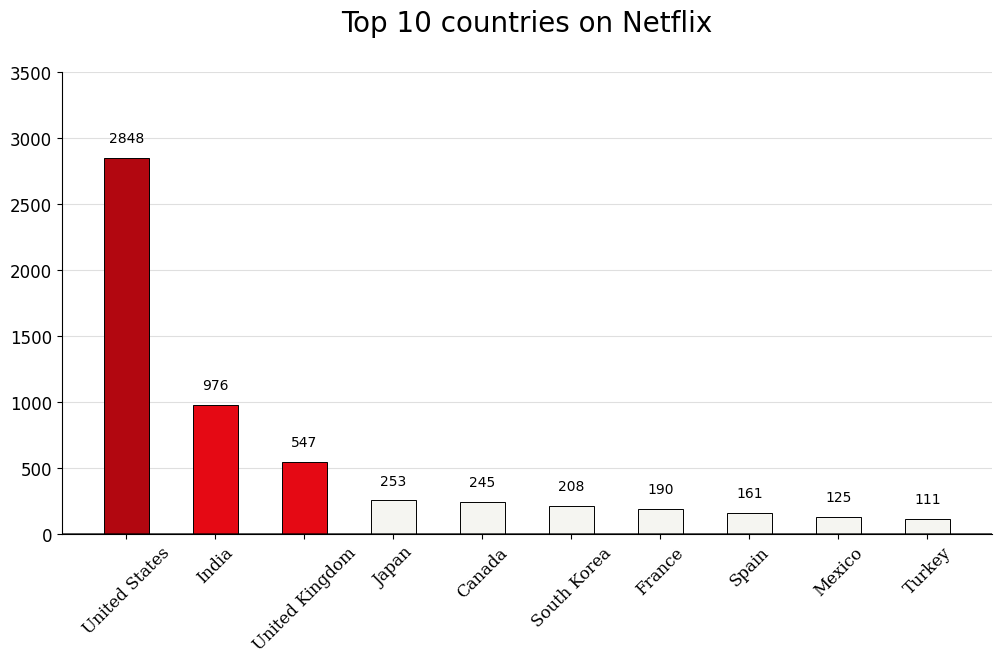

In [9]:
color_map = [cmap[-1] for _ in range(10)]
color_map[0] = cmap[1]
color_map[1] = color_map[2] =  cmap[-2] 

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(list(countries_count.keys())[:10], list(countries_count.values())[:10], width=0.5, 
       edgecolor='black',
       linewidth=0.7, color=color_map)

for i in list(countries_count.keys())[:10]:
    ax.annotate(f"{countries_count[i]}", 
                   xy=(i, countries_count[i] + 150),
                   va = 'center', ha='center',fontweight='light')

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(list(countries_count.keys())[:10], fontfamily='serif', rotation=45)

plt.title("Top 10 countries on Netflix\n", loc = "center", fontdict = {'fontsize' : 20, 'fontweight' : 5})
ax.grid(axis='y', linestyle='-', alpha=0.4)   

grid_y_ticks = np.arange(0, 4000, 500)
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

### Year
We can plot the number of shows added per year to see the evolution of Netflix from 2008 to 2020

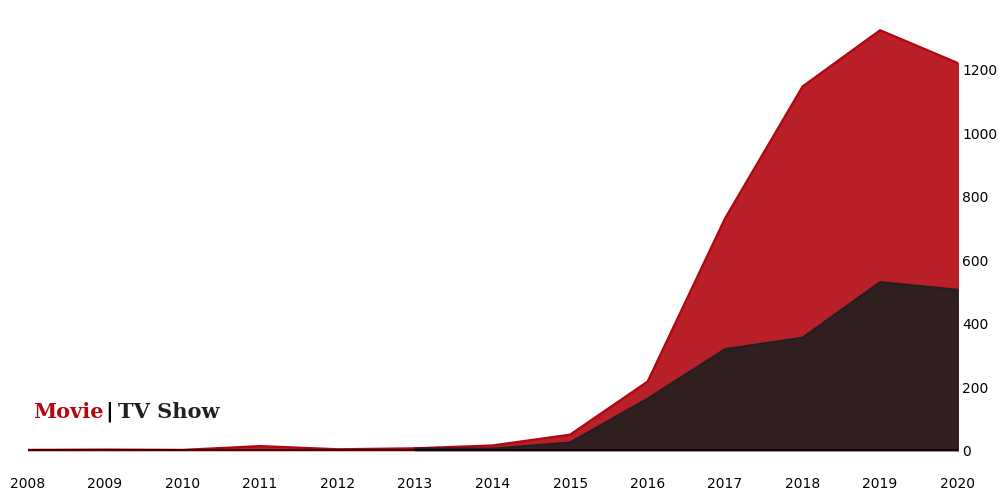

In [10]:
df['year_added'] = df['date_added'].dt.year

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ["#b20710", "#221f1f"]

for i, mtv in enumerate(df['type'].value_counts().index):
    mtv_rel = df[df['type']==mtv]['year_added'].value_counts().sort_index()
    ax.plot(mtv_rel.index, mtv_rel, color=color[i], label=mtv)
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], alpha=0.9)
    
ax.yaxis.tick_right()
    
ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

#ax.set_ylim(0, 50)
#ax.legend(loc='upper left')
for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.grid(False)

ax.set_xlim(2008,2020)
plt.xticks(np.arange(2008, 2021, 1))


fig.text(0.13,0.2,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19,0.2,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.2,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

Here i created some dictionaries and dataframes containing statistics related to the actors, which will be useful later for analysis and graph building.

In [11]:
## Actors
actors_cast = df.cast
actors_cast = actors_cast.apply(lambda x:x.split(","))
actors_cast = [x.lstrip() for y in actors_cast for x in y]
actor_count = Counter(actors_cast)
actor_count = dict(sorted(actor_count.items(), reverse = True, key=lambda item: item[1]),)

In [12]:
actor_df = pd.DataFrame({"Actors": list(actor_count.keys()), "Films" : list(actor_count.values())})
actor_df.set_index("Actors", inplace = True)

In [13]:
for country in countries_count.keys():
    actor_df[country] = np.zeros(actor_df.shape[0], dtype = int)
actor_df["Unknown"] = np.zeros(actor_df.shape[0], dtype = int)

In [14]:
for idx,actors in enumerate(df.cast):
    actors = actors.split(",")
    actors = [x.lstrip() for x in actors]
    for actor in actors:
        actor_df.loc[actor, df.iloc[idx,5]] += 1

## Graph
here i built the first graph containing all the actors in our dataset, connected if they did a film together. Weight was assigned accordingly to the number of films the 2 actors performed in together.

In [15]:
G = nx.Graph()
G.add_nodes_from(set(actors_cast))
G.number_of_nodes()

36439

In [16]:
def find_couples(lst):
    couples = []
    for i in range(len(lst)):
        for j in range(i + 1, len(lst)):
            couple = (lst[i], lst[j])
            couples.append(couple)
    return couples

In [17]:
def add_edge_with_weight(graph, node1, node2):
    if graph.has_edge(node1, node2):
        current_weight = graph[node1][node2].get('weight', 0)
        graph[node1][node2]['weight'] = current_weight + 1
    else:
        graph.add_edge(node1, node2, weight=1)

In [18]:
tot = 0
for lst in df.cast:
    lst = lst.split(",")
    lst = [a.lstrip() for a in lst]
    temp = find_couples(lst)
    for couples in temp:
        add_edge_with_weight(G,couples[0], couples[1])
    tot += len(temp)

In [19]:
print(f"The graph presents {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

The graph presents 36439 nodes and 289207 edges


## Data cleaning through components
By a first brief analysis on the graph we can spot a problem with the number of connected components. 

In [20]:
conn_components = list(nx.connected_components(G))
print(f"There are a total of {len(conn_components)} components in our graph")

There are a total of 874 components in our graph


As we can see from the example below, there are some films in which only one actor performed.

In [21]:
df.iloc[3384,2:5]

title       Awake: The Million Dollar Game
director                               NaN
cast                           James Davis
Name: 3384, dtype: object

Here we can see how all the actors in a cast performed only in that film, creating a disconnected component.

In [22]:
for idx,lst in enumerate(df.cast):
    lst = lst.split(",")
    lst = [a.lstrip() for a in lst]
    if 'Constance Nunes' in lst:
        index = idx
        actors_one_film = lst
        break

In [23]:
actor_df.loc[actors_one_film]

,Films,United States,India,United Kingdom,Japan,Canada,South Korea,France,Spain,Mexico,...,Paraguay,Soviet Union,Georgia,Iran,Venezuela,Slovenia,Guatemala,Jamaica,Somalia,Unknown
Actors,,,,,,,,,,,,,,,,,,,,,
Mark Towle,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Shawn Pilot,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Constance Nunes,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Tony Quinones,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
"Mike ""Caveman"" Pyle",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


We can remove from the graphs all the nodes which are in a disconnected component and have edges only of weight 1.

In [24]:
to_rem = []
for comp in conn_components:
    comp = list(comp)
    if len(comp) == 1:
        to_rem.append(comp[0])
    else:
        tot = 0
        for actor in comp:
            tot += actor_df.loc[actor,"Films"]
        if tot == len(comp):
            to_rem.extend(comp)
print(f"There are {len(to_rem)} actors to remove from our analysis")            

There are 2978 actors to remove from our analysis


In [25]:
for actor in to_rem:
    idx = 0
    for lst in df.cast:
        lst = lst.split(",")
        lst = [a.lstrip() for a in lst]
        if actor in lst:
            df = df.drop(idx)
            df.reset_index(inplace = True, drop = True)
        else:
            idx += 1

## New_graph

In [26]:
actors_cast = df.cast
actors_cast = actors_cast.apply(lambda x:x.split(","))
actors_cast = [x.lstrip() for y in actors_cast for x in y]

In [27]:
G = nx.Graph()
G.add_nodes_from(set(actors_cast))

In [28]:
tot = 0
for lst in df.cast:
    lst = lst.split(",")
    lst = [a.lstrip() for a in lst]
    temp = find_couples(lst)
    for couples in temp:
        add_edge_with_weight(G,couples[0], couples[1])
    tot += len(temp)

In [29]:
print(f"The new graph presents {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

The new graph presents 33461 nodes and 280378 edges


In [30]:
conn_components = list(nx.connected_components(G))

In [31]:
print(f"We now have {len(conn_components)} components inside our graph")

We now have 52 components inside our graph


### Components analysis
We can now plot the size of the components to analyze their behavior

In [32]:
lengths = []
for comp in conn_components:
    lengths.append(len(comp))
lengths = sorted(lengths)

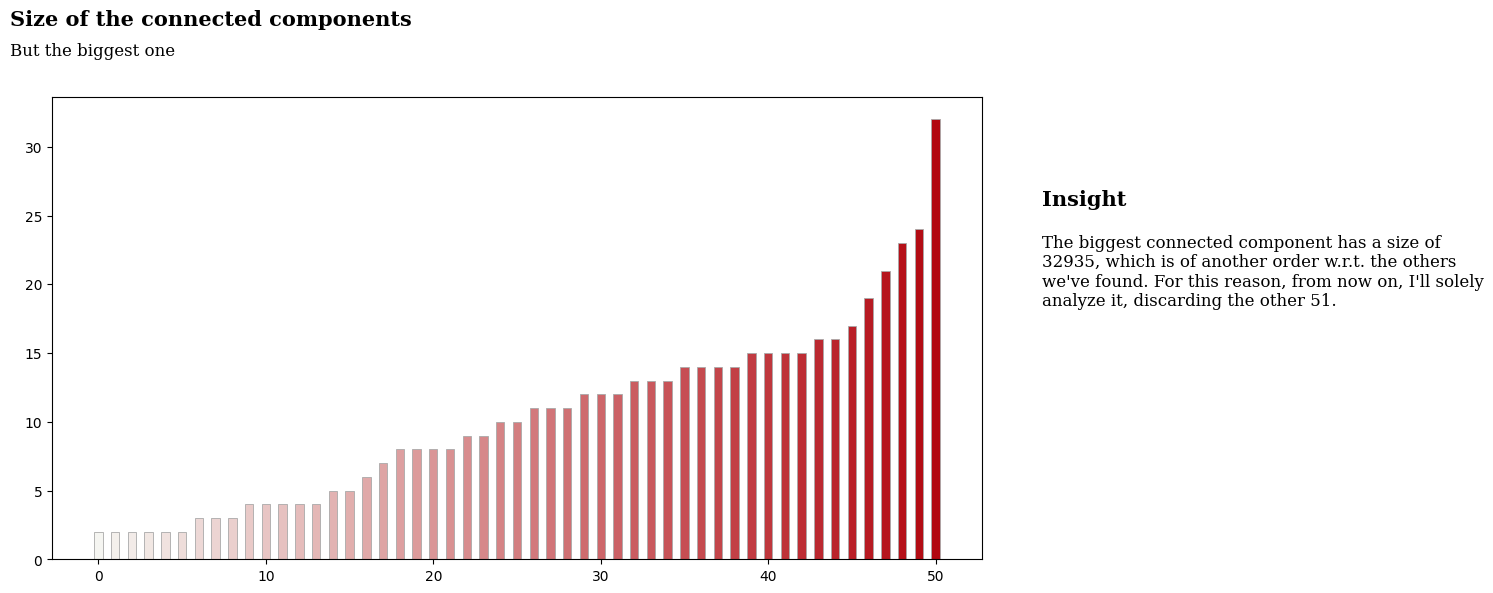

In [33]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.bar(range(len(lengths)-1), lengths[:-1], width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6, color= get_color_gradient(cmap[1], cmap[-1], len(lengths)-1)[::-1])

fig.text(0.09, 1, 'Size of the connected components', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'But the biggest one', fontsize=12, fontweight='light', fontfamily='serif')
fig.text(0.95, 0.7, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.95, 0.5, f'''
The biggest connected component has a size of
{lengths[-1]}, which is of another order w.r.t. the others
we've found. For this reason, from now on, I'll solely
analyze it, discarding the other 51.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')
plt.show()

## Cleaned graph
We can create a subgraph composed only by nodes present in the biggest component, discarding the other 526 nodes and building the final graph.

In [34]:
G = G.subgraph(conn_components[0])

In [35]:
print(f"The final graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

The final graph has 32935 nodes and 278379 edges


In [36]:
max_weight_edges = []
for u, v, weight in G.edges(data='weight'):
    if weight > 15:
        #max_weight = weight
        max_weight_edges .append( [(u, v, weight)])

In [37]:
print("We can plot the best friends in our graph, so the edges with the higest weight (greater than 15)")
for edge in max_weight_edges:
    print(f"{edge[0][0]}-{edge[0][1]}-{edge[0][2]}")

We can plot the best friends in our graph, so the edges with the higest weight (greater than 15)
Jigna Bhardwaj-Vatsal Dubey-18
Jigna Bhardwaj-Julie Tejwani-21
Jigna Bhardwaj-Rupa Bhimani-20
Jigna Bhardwaj-Rajesh Kava-20
Julie Tejwani-Vatsal Dubey-18
Julie Tejwani-Rupa Bhimani-31
Julie Tejwani-Rajesh Kava-24
Rupa Bhimani-Vatsal Dubey-18
Rupa Bhimani-Rajesh Kava-22
Rajesh Kava-Vatsal Dubey-17


### Degree distribution
We can plot the degree distribution to see if the network respects the power law.

In [38]:
dictio = {}
for actor in G.nodes():
    dictio[actor] = G.degree(actor, weight = "weight")
dictio = dict(sorted(dictio.items(), reverse = True, key = lambda x : x[1]))

In [39]:
degrees =  sorted([d for n, d in G.degree(weight="weight")])
dict_degrees = dict(Counter(degrees))
k = list(dict_degrees.keys())
pk = list(dict_degrees.values())
pk = pk / np.sum(pk)

In [40]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(np.log(k[8:]), np.log(pk[8:]))
gamma = 1 + 1 / np.mean(np.log(np.array(degrees) / 7))

def retta(x, slope):
    return -slope * x + intercept

In [41]:
gamma

2.6426176141300566

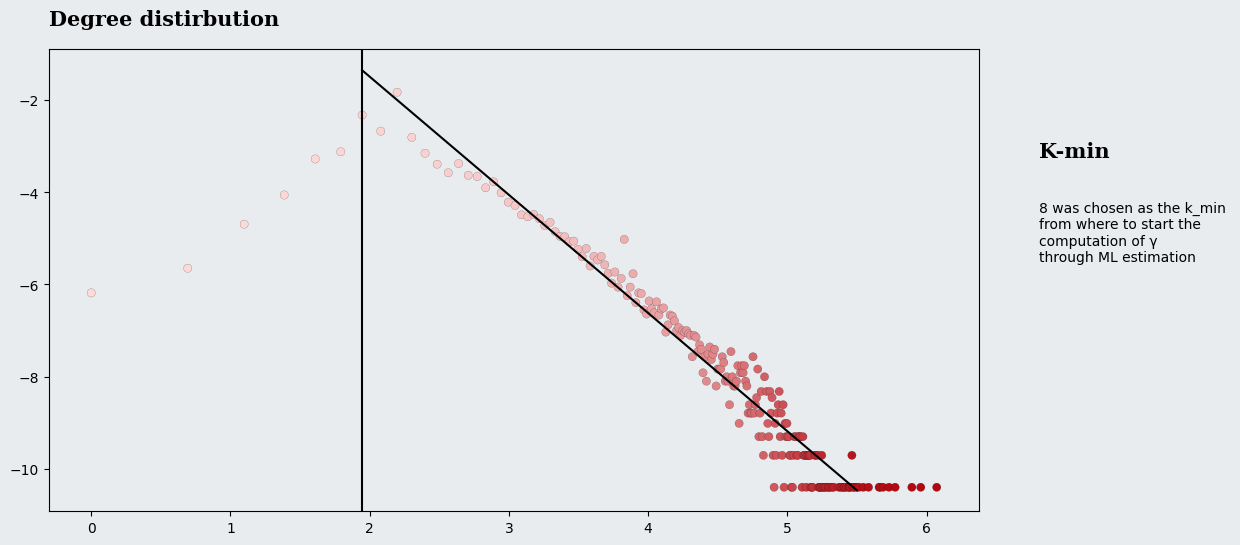

In [42]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.scatter(np.log(k), np.log(pk), color= get_color_gradient(cmap[1], "#FEDADA", len(pk))[::-1], edgecolors="black",linewidths=.1)
ax.axvline(x = np.log(7), color = "black")
fig.text(0.125, 0.92, 'Degree distirbution', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.95, 0.7, 'K-min', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.95, 0.5, '''
8 was chosen as the k_min \nfrom where to start the 
computation of γ \nthrough ML estimation
''')
fig.set_facecolor('#e9ecef')
ax.set_facecolor('#e9ecef')
ax.plot([np.log(7),5.5], [retta(np.log(7), -slope), retta(5.5,-slope)], color = "black")

## Page_Rank
We can compute the page-rank values of the nodes in our network and compare them with the degree to study imortant nodes.

In [43]:
pr_values = dict(sorted(nx.pagerank(G).items(), key = lambda x:x[1],reverse=True))

In [44]:
for key,val in pr_values.items():
    pr_values[key] = [val]
    pr_values[key].append(G.degree(key, weight = "weight"))

In [45]:
pr = [val[0] for val in pr_values.values()]
dg = [val[1] for val in pr_values.values()]

In [46]:
len(pr)

32935

In [47]:
import matplotlib as mpl
COLOR = 'w'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

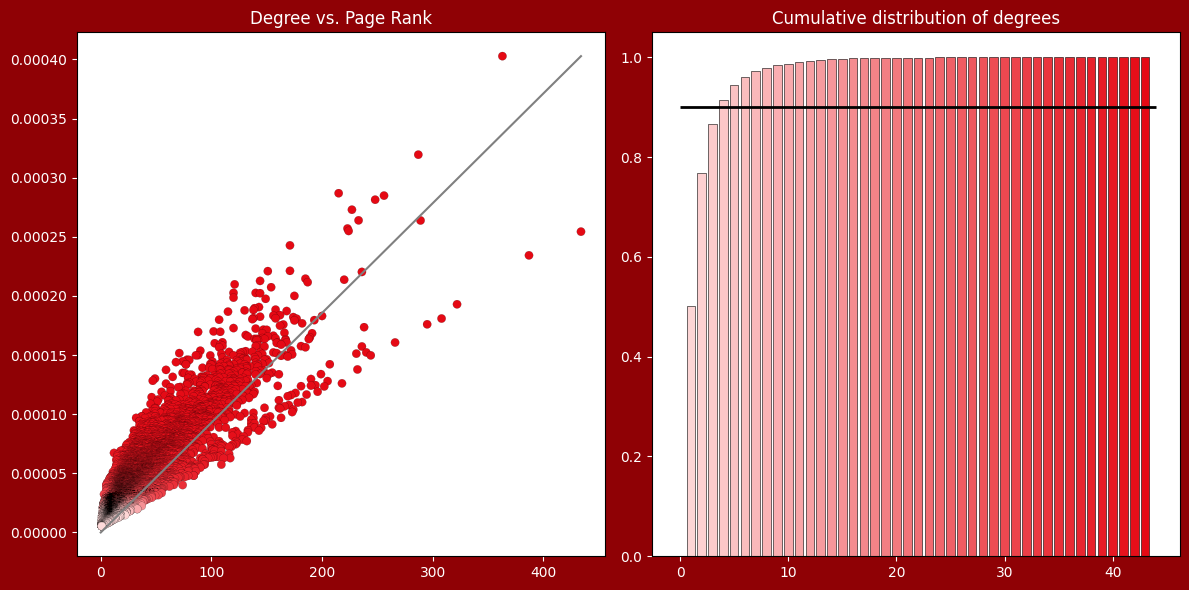

In [48]:
col_sc = get_color_gradient(cmap[2], "#FEDADA", 390)
new_col = []
for col in col_sc:
    new_col.extend([col]*80)
new_col.extend([col] * (800+935))
    
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].scatter(dg, pr, color = new_col , edgecolors="black", linewidths=.1)
ax[0].plot([0,max(dg)],[0,max(pr)], color = "grey")
ax[0].set_title("Degree vs. Page Rank")

cumulative = np.array([])
dg = np.array(dg)
for i in np.linspace(0,max(dg),44):
    cumulative = np.append(cumulative, sum(dg<i))
fig.set_facecolor('#8f0105')
    
cumulative /= len(dg)
ax[1].bar(range(len(cumulative)),cumulative, color = get_color_gradient(cmap[2], "#FEDADA", len(cumulative))[::-1], edgecolor = "black", linewidth = .4)
ax[1].hlines(y=0.9, xmin=0, xmax=44, linewidth=2, color = "black")
ax[1].set_title("Cumulative distribution of degrees")
fig.tight_layout()

In [49]:
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

### Examples of important actor
Actors above and below the 45° line.

In [50]:
slope, intercept, r_value, p_value, std_err = linregress([0,max(dg)],[0,max(pr)])

In [51]:
print(f"the ratio between the page_rank value and the degree is {round(slope,9)}")

the ratio between the page_rank value and the degree is 9.28e-07


In [52]:
print("Plotted below some examples of actor Above the line:\n")
for key,val in pr_values.items():
    if val[1] > 200 and val[1] * slope < val[0]:
        print(key)

Plotted below some examples of actor Above the line:

Anupam Kher
Shah Rukh Khan
Naseeruddin Shah
Samuel L. Jackson
Akshay Kumar
Om Puri
Paresh Rawal
Boman Irani
Amitabh Bachchan
Fred Armisen
Adam Sandler


In [53]:
print("And below the line:\n")
for key,val in pr_values.items():
    if val[1] > 250 and val[1] * slope > val[0]:
        print(key)

And below the line:

Fred Tatasciore
Takahiro Sakurai
Yuki Kaji
Yuichi Nakamura
Daisuke Ono
Junichi Suwabe
Jun Fukuyama


## Assortativity

In [54]:
assortativity = nx.degree_assortativity_coefficient(G, weight='weight')
print("Weighted assortativity of the graph:", assortativity)

Weighted assortativity of the graph: 0.2676521413684809


In [55]:
neigh_degree_graph = nx.average_neighbor_degree(G, weight = "weight")
neigh_degree_plot = {a:[] for a in k}
for key,val in neigh_degree_graph.items():
    deg = G.degree(key, weight = "weight")
    neigh_degree_plot[deg].append(val)

In [56]:
x = []
y = []
for key,val in neigh_degree_plot.items():
    x.extend([key] * len(val))
    y.extend(val)
    
x_2 = list(neigh_degree_plot.keys())
y_2 = [np.mean(neigh_degree_plot[key]) for key in neigh_degree_plot.keys()]

In [57]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(x_2), np.log(y_2))

In [1]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.scatter(np.log(x), np.log(y), color= '#eeadaf', edgecolors="black", linewidths=.1)
ax.scatter(np.log(x_2), np.log(y_2), color= cmap[1], edgecolors="black", linewidths=.2)
fig.text(0.125, 0.95, 'Neighboring degree', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.125, 0.91, 'We can spot an assortative behavior in our Network', fontsize=12, fontweight='light', fontfamily='serif')
ax.plot([0,5.5], [retta(0,-slope), retta(5.5,-slope)], color = "black")

NameError: name 'plt' is not defined

#### 3 actors comparison
Plot the degree of neighbors of 3 random actors with 3 different degrees to have an example of assortativity

In [59]:
actor_1 = 'Kari Wahlgren' #182
actor_2 = 'James Marsden' #132
actor_3 = 'Amr Youssef' #32

In [60]:
node_neighbors_1 = list(G.neighbors(actor_1))
lst_1 = [G.degree(k, weight = "weight") for k in node_neighbors_1]

node_neighbors_2 = list(G.neighbors(actor_2))
lst_2 = [G.degree(k, weight = "weight") for k in node_neighbors_2]

node_neighbors_3 = list(G.neighbors(actor_3))
lst_3 = [G.degree(k, weight = "weight") for k in node_neighbors_3]

lst_1 = sorted(lst_1, reverse = True)
lst_2 = sorted(lst_2, reverse = True)
lst_3 = sorted(lst_3, reverse = True)

In [61]:
lst_2 += [0] * (len(lst_1) - len(lst_2))
lst_3 += [0] * (len(lst_1) - len(lst_3))
x = range(len(lst_1))

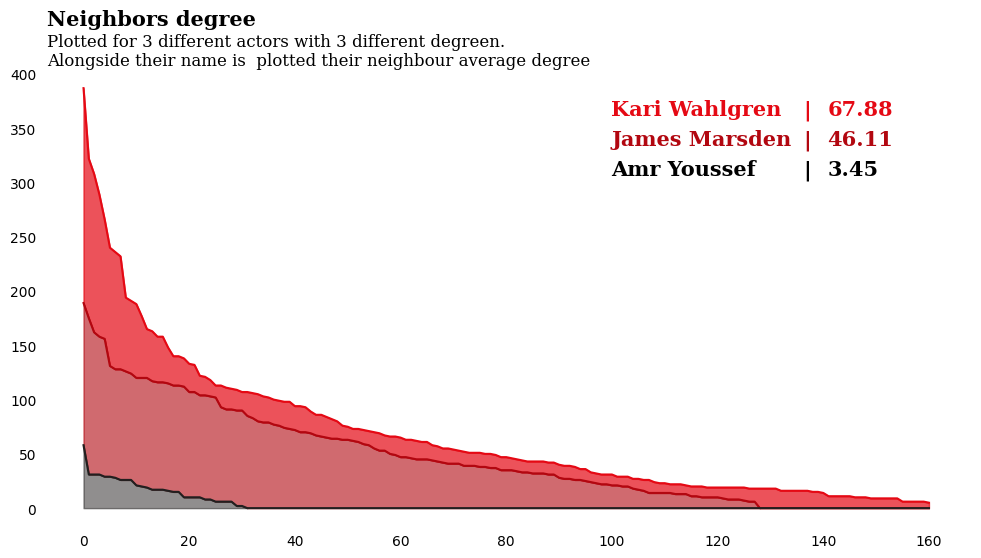

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x, lst_1, cmap[2])
ax.plot(x, lst_2, cmap[1])
ax.plot(x, lst_3, cmap[0])

ax.fill_between(x, lst_1, lst_2, where=[x > y for x,y in zip(lst_1 , lst_2)], color=cmap[2], alpha=0.7, interpolate=True, label='sin(x) > cos(x)')
ax.fill_between(x, lst_2, lst_3, where=[x > y for x,y in zip(lst_2 , lst_3)], color=cmap[1], alpha=0.6, interpolate=True, label='sin(x) > cos(x)')
ax.fill_between(x, lst_3, [0]*len(lst_3), where=[x > y for x,y in zip(lst_3 , [0]*len(lst_3))], color=cmap[0], alpha=0.5, interpolate=True, label='sin(x) > cos(x)')

for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

fig.text(0.13, 0.95, 'Neighbors degree', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.85, 
'''Plotted for 3 different actors with 3 different degreen.
Alongside their name is  plotted their neighbour average degree
'''

, fontsize=12, fontweight='light', fontfamily='serif')



fig.text(0.6,0.8,f"{actor_1}", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap[2])
fig.text(0.6,0.75,f"{actor_2}", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap[1])
fig.text(0.6,0.7,f"{actor_3}", fontweight="bold", fontfamily='serif', fontsize=15, color='black')

fig.text(0.76,0.8,f"|", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap[2])
fig.text(0.76,0.75,f"|", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap[1])
fig.text(0.76,0.7,f"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')

fig.text(0.78,0.8,f"{np.round(np.mean(lst_1),2)}", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap[2])
fig.text(0.78,0.75,f"{np.round(np.mean(lst_2),2)}", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap[1])
fig.text(0.78,0.7,f"{np.round(np.mean(lst_3),2)}", fontweight="bold", fontfamily='serif', fontsize=15, color='black')

ax.tick_params(axis=u'both', which=u'both',length=0) 

## Louvain algorithm and the choice of γ
### From networkX to iGraph

In [63]:
def entropy(Y):
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

def jEntropy(Y,X):
    YX = np.c_[Y,X]
    return entropy(YX)

def cEntropy(Y, X):
    return jEntropy(Y, X) - entropy(X)

def gain(Y, X):
    return entropy(Y) - cEntropy(Y,X)

def NVI(p,q):
    return (cEntropy(p, q) + cEntropy(q,p))/len(p)

In [64]:
weights = []
edge_list = []
for edge in G.edges:
    edge_list.append(edge)
    weights.append(G.get_edge_data(edge[0], edge[1])["weight"])

In [65]:
G_ig = ig.Graph()
G_ig.add_vertices(list(G.nodes()))
G_ig.add_edges(edge_list)
G_ig.es["weight"] = weights

In [66]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [67]:
random.seed(1234)
gammas = np.linspace(0.5,3.5,31)
modularities = []
num_communities = []
comm_sizes = []
nvi = []
nmi = []
for _ in range(5):
    temp_1 = G_ig.community_multilevel(resolution= 0.4, weights="weight")
    for i in gammas:
        temp = G_ig.community_multilevel(resolution= i, weights="weight")
        num_communities.append(len(temp))
        modularities.append(temp.modularity)
        comm_sizes.append([len(x) for x in temp])
        nvi.append(NVI(temp.membership,temp_1.membership))
        nmi.append(normalized_mutual_info_score(temp.membership, temp_1.membership))
        temp_1 = temp
    
    

In [68]:
avg_mod = []
avg_nmi = []
avg_nvi = []
avg_num_comm = []
def avg(lst):
    average = []
    for i in range(31):
        temp = []
        for j in range(5):
            temp.append(lst[i + 31 * j])
        average.append(np.mean(temp))
    return average

avg_mod = avg(modularities)
avg_nmi = avg(nmi)
avg_nvi = avg(nvi)
avg_num_comm = avg(num_communities)

avg_comm_size = []
for i in range(31):
    temp = []
    for j in range(5):
        temp.append(len(comm_sizes[i + 31 * j]))
    avg_comm_size.append(np.mean(temp))


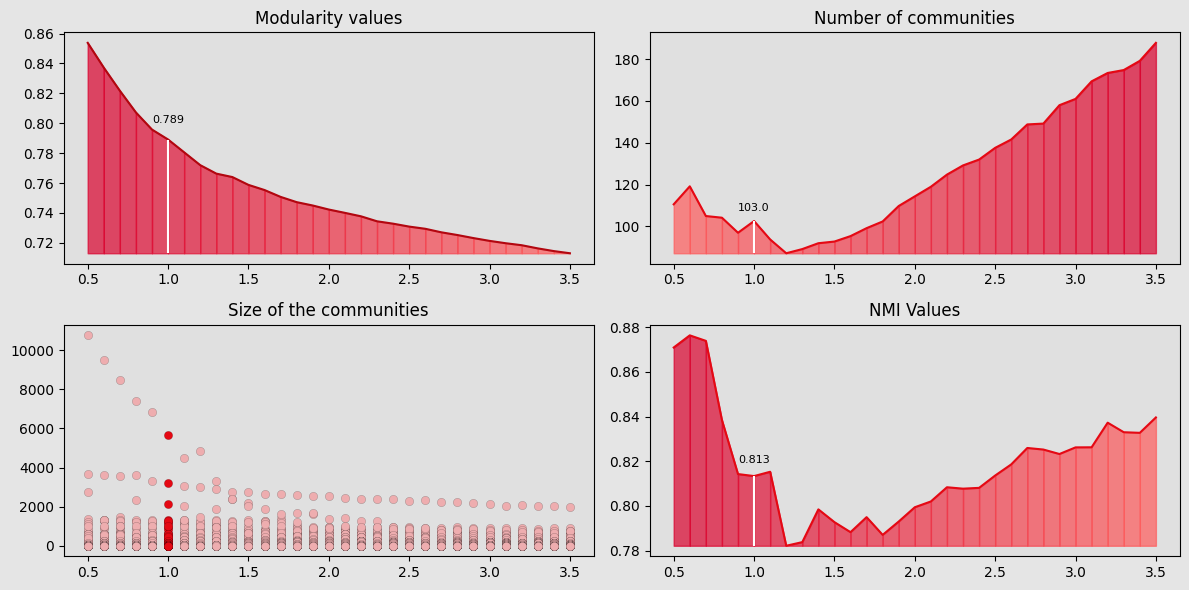

In [69]:
point_index = 5
cmap_2 = get_color_gradient("#DA012D", "#FF5c5c", len(gammas)-1)

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0,0].plot(gammas, avg_mod, color = cmap[1])

ax[0,0].set_title("Modularity values")
ax[0,0].vlines(gammas[point_index], ymin = min(avg_mod), ymax = avg_mod[point_index], color = "w")

for i in range(len(gammas) - 1):
    ax[0,0].fill_between(gammas[i:i+2], min(avg_mod),avg_mod[i:i+2], color=cmap_2[i], alpha = 0.7)
    
ax[0,0].text(gammas[point_index], avg_mod[point_index] + 0.01, f'{np.round(avg_mod[point_index],3)}',
        fontsize=8, ha='center', va='bottom')

ax[0,1].plot(gammas, avg_num_comm, color = cmap[2])
ax[0,1].set_title("Number of communities")
ax[0,1].vlines(gammas[point_index], ymin = min(avg_num_comm), ymax = avg_num_comm[point_index], color = "w")

for i in range(len(gammas) - 1):
    ax[0,1].fill_between(gammas[i:i+2], min(avg_num_comm),avg_num_comm[i:i+2], color=cmap_2[::-1][i], alpha = 0.7)
ax[0,1].text(gammas[point_index], avg_num_comm[point_index] + 4, f'{np.round(avg_num_comm[point_index],0)}',
        fontsize=8, ha='center', va='bottom')


c_grad = ["#eeadaf"]*31
c_grad[point_index]  = cmap[2]
for idx,comm in enumerate(comm_sizes[:31]):
    ax[1,0].scatter([gammas[idx]]*len(comm), comm, color = c_grad[idx],edgecolors="black", linewidths=.1)
ax[1,0].set_title("Size of the communities")


ax[1,1].plot(gammas, avg_nmi, color = cmap[2])

ax[1,1].set_title("NMI Values")
ax[1,1].vlines(gammas[point_index], ymin = min(avg_nmi), ymax = avg_nmi[point_index], color = "w")
for i in range(len(gammas) - 1):
    ax[1,1].fill_between(gammas[i:i+2], min(avg_nmi),avg_nmi[i:i+2], color=cmap_2[i], alpha = 0.7)
ax[1,1].text(gammas[point_index], avg_nmi[point_index] + 0.005, f'{np.round(avg_nmi[point_index],3)}',
        fontsize= 8, ha='center', va='bottom')

fig.set_facecolor((0, 0, 0, 0.1))
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_facecolor((0.7, 0.7, 0.7, .1))

        


fig.tight_layout()

## Analyzing communities

Results were run and stored to avoid randomicity, even if the seed was set.
```python
random.seed(123)
louvain = G_ig.community_multilevel(resolution = 1, weights="weight")
assignment = louvain.membership
"We obtained a total of 112 communities, with the biggest one having 5832 nodes"
"Modularity of the community assignemnt is of 0.794
```

In [70]:
cntrs = list(countries_count.keys())
cntrs.append("Unknown")

In [71]:
print("Results can be uploaded from the .json file")
import json
file_path = 'dictionary.json'
with open(file_path, 'r') as json_file:
    communities_node = json.load(json_file)

Results can be uploaded from the .json file


In [72]:
communities_node = {int(k):v for k,v in communities_node.items()}

In [73]:
communities_nat = {k : {x : 0 for x in list(cntrs)} for k in communities_node.keys()}

In [74]:
for j in communities_node.keys():
    temp = {}
    for actor in communities_node[j]:
        temp = actor_df.loc[actor,:]
        temp = temp[temp!=0].drop("Films")
        for key,val in temp.items():
            communities_nat[j][key] += val
    communities_nat[j] = {k: v for k, v in communities_nat[j].items() if v > 0 }

In [75]:
import copy

In [76]:
communities_nat_perc = copy.deepcopy(communities_nat)
for j in communities_node.keys():
    somma = sum(communities_nat_perc[j].values())
    for k,v in communities_nat_perc[j].items():
        communities_nat_perc[j][k] = round(communities_nat_perc[j][k] / somma, 3)

In [77]:
communities_nat_highest = {k : {"Country": "", "Perc": 0, "Size" : 0} for k in  communities_node.keys()}
for k in communities_node.keys():
    chiave = max(communities_nat_perc[k], key=communities_nat_perc[k].get)
    communities_nat_highest[k]["Country"] += chiave
    communities_nat_highest[k]["Perc"] += communities_nat_perc[k][chiave]
    communities_nat_highest[k]["Size"] += len(communities_node[k])

In [78]:
perc_df = pd.DataFrame(communities_nat_highest).T.sort_values(by = "Perc", ascending = False)
print(f"We have {sum(perc_df.Perc == 1)} communities composed only by actors of 1 country")
one_country = perc_df[perc_df.Perc == 1]      

We have 36 communities composed only by actors of 1 country


In [79]:
one_country = one_country.groupby(by = "Country").sum().sort_values(by = "Perc", ascending = False)
one_country.columns = ["n_comm","tot_size"]

101 is an example of a community having only american actors

In [80]:
communities_node[101]

['Marlo Williams',
 'Tracey Ashley',
 'Chaunté Wayans',
 'Aida Rodriguez',
 'Flame Monroe',
 'April Macie']

In [81]:
len(list(G.neighbors("Tiffany Haddish")))

119

In [82]:
df.iloc[1109,2]

'Tiffany Haddish Presents: They Ready'

### 2 biggest communities - brief_analysis

In [83]:
perc_df.sort_values(by = "Size", ascending = False).iloc[:2]

,Country,Perc,Size
7,United States,0.826,5832
1,India,0.917,3218


#### Community 1

In [84]:
node_1 = communities_node[1]
comm_perc_1 = dict(sorted(communities_nat_perc[1].items(), key = lambda x:x[1], reverse = True))

node_7 = communities_node[7]
comm_perc_7 = dict(sorted(communities_nat_perc[7].items(), key = lambda x:x[1], reverse = True))

In [85]:
print(f"Community 1 is composed by {perc_df.loc[1,'Size']} actors, while community 7 is composed by {perc_df.loc[7,'Size']} actors")

Community 1 is composed by 3218 actors, while community 7 is composed by 5832 actors


In [86]:
n_states = 5
print(f"The top {n_states} nationalities in community 1 are:\n")
take(n_states, comm_perc_1.items())

n_states = 5
print(f"\nThe top {n_states} nationalities in community 7 are:\n")
take(n_states, comm_perc_7.items())

The top 5 nationalities in community 1 are:

India: 0.917
Unknown: 0.033
Pakistan: 0.019
United States: 0.009
United Kingdom: 0.006

The top 5 nationalities in community 7 are:

United States: 0.826
United Kingdom: 0.05
Canada: 0.032
Unknown: 0.025
France: 0.012


In [87]:
print(f"The top {5} actors in community 1 are:\n")

pr_values_1 = dict((k, pr_values[k]) for k in node_1)
pr_values_1 = dict(sorted(pr_values_1.items(), key = lambda x : x[1], reverse = True))
take(5, pr_values_1.items())

print(f"\nThe top {5} actors in community 7 are:\n")

pr_values_7 = dict((k, pr_values[k]) for k in node_7)
pr_values_7 = dict(sorted(pr_values_7.items(), key = lambda x : x[1], reverse = True))
take(5, pr_values_7.items())

The top 5 actors in community 1 are:

Anupam Kher: [0.0004027448929784275, 363]
Shah Rukh Khan: [0.00031945500056511784, 287]
Naseeruddin Shah: [0.00028684506415794825, 215]
Akshay Kumar: [0.0002813829493542974, 248]
Om Puri: [0.0002729162815772798, 227]

The top 5 actors in community 7 are:

Samuel L. Jackson: [0.0002848334387650737, 256]
Nicolas Cage: [0.00022122721558339855, 171]
Bruce Willis: [0.00022095979685013024, 151]
Fred Armisen: [0.0002203080059991875, 236]
Adam Sandler: [0.00021373073659107755, 220]


In [88]:
pr_1 = [x[0] for x in list(pr_values_1.values())]
dg_1 = [x[1] for x in list(pr_values_1.values())]
pr_7 = [x[0] for x in list(pr_values_7.values())]
dg_7 = [x[1] for x in list(pr_values_7.values())]
x_1 = range(len(pr_1))
x_7 = range(len(pr_7))

In [89]:
mass_1 = 0
actor_com_1 = None
for actor in node_1:
    if actor_df.loc[actor,"Films"] > mass_1:
        mass_1 = actor_df.loc[actor,"Films"]
        actor_com_1 = actor
        
mass_7 = 0
actor_com_7 = None
for actor in node_7:
    if actor_df.loc[actor,"Films"] > mass_7:
        mass_7 = actor_df.loc[actor,"Films"]
        actor_com_7 = actor

In [90]:
print(f"The actor with the highest n° of films in community 1 is {actor_com_1}, with {mass_1} films")
print(f"The actor with the highest n° of films in community 7 is {actor_com_7}, with {mass_7} films")

The actor with the highest n° of films in community 1 is Anupam Kher, with 43 films
The actor with the highest n° of films in community 7 is Samuel L. Jackson, with 24 films


In [91]:
pr_comparison = []
for i in range(len(pr_1)):
    if pr_1[i] > pr_7[i]:
        pr_comparison.append(1)
    else:
        pr_comparison.append(7)

In [92]:
print(f"If we sort the Page Rank values of actors and compare them, the first {pr_comparison.index(7)} Indian actors have a higher pr values, while form that point on the american are always above ")

If we sort the Page Rank values of actors and compare them, the first 17 Indian actors have a higher pr values, while form that point on the american are always above 


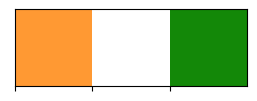

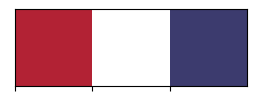

In [93]:
cmap_1 = ["#FF9933", "#FFFFFF", "#138808"]
cmap_7 = ["#B22234", "#FFFFFF", "#3C3B6E"]
sns.palplot(cmap_1)
sns.palplot(cmap_7)

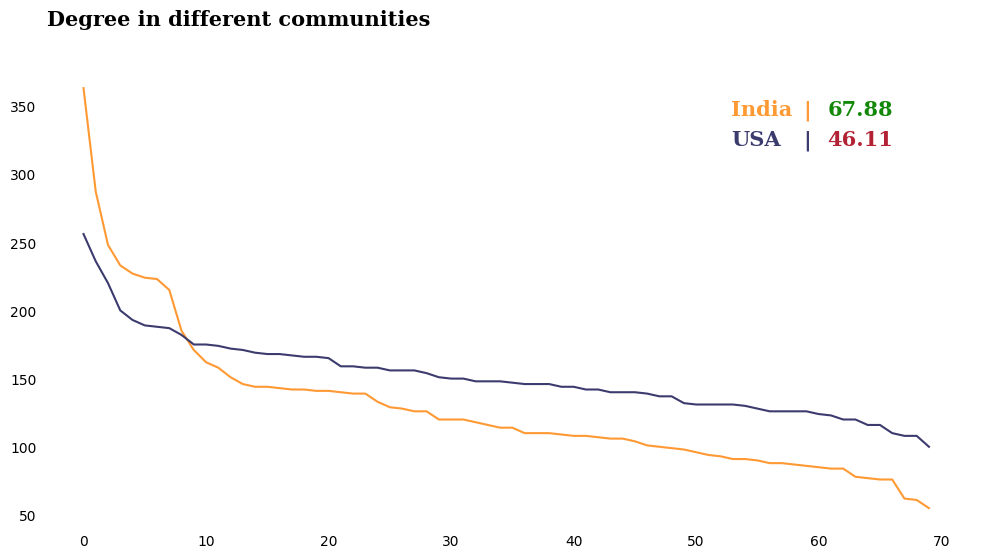

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
to_plot = 70
ax.plot(range(to_plot), sorted(dg_1[:to_plot], reverse = True), "#FF9933")
ax.plot(range(to_plot), sorted(dg_7[:to_plot], reverse = True), "#3C3B6E")


for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

fig.text(0.13, 0.95, 'Degree in different communities', fontsize=15, fontweight='bold', fontfamily='serif')
#fig.text(0.13, 0.85, 
'''Plotted for 3 different actors with 3 different degreen.
Alongside their name is  plotted their neighbour average degree
'''

fig.text(0.7,0.8,f"India", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap_1[0])
fig.text(0.7,0.75,"USA", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap_7[2])



fig.text(0.76,0.8,f"|", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap_1[0])
fig.text(0.76,0.75,f"|", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap_7[2])

fig.text(0.78,0.8,f"{np.round(np.mean(lst_1),2)}", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap_1[2])
fig.text(0.78,0.75,f"{np.round(np.mean(lst_2),2)}", fontweight="bold", fontfamily='serif', fontsize=15, color=cmap_7[0])


, fontsize=12, fontweight='light', fontfamily='serif')

ax.tick_params(axis=u'both', which=u'both',length=0) 

In [109]:
idx = 0
for a,b in zip(dg_1, dg_7):
    if a < b:
        print(idx)
        break
    idx += 1

10


In [110]:
G.degree("Takahiro Sakurai", weight = "weight")

434

#### Betweeness

As before results were run once and exported to a .csv file to avoid recomputing them every time.
```python
graph_1 = G.subgraph(node_1)
graph_7 = G.subgraph(node_7)


betweenness_1 = nx.betweenness_centrality(graph_1)
betweenness_7 = nx.betweenness_centrality(graph_7)
```

In [95]:
import json

file_path = 'betweenness_1'
with open(file_path, 'r') as json_file:
    betw_1 = json.load(json_file)
    
file_path = 'betweenness_7'
with open(file_path, 'r') as json_file:
    betw_7 = json.load(json_file)

In [96]:
print("Top-5 Indian actors\n")
take(5, betw_1.items())

Top-5 Indian actors

Anupam Kher: 0.03970029549871727
Naseeruddin Shah: 0.03456400327298101
Om Puri: 0.03363599595269236
Shah Rukh Khan: 0.032196090366569376
Kay Kay Menon: 0.029667416057122867


In [97]:
print("Top-5 American actors\n")
take(5, betw_7.items())

Top-5 American actors

Samuel L. Jackson: 0.020877531703074867
James Franco: 0.012671154869248694
Fred Armisen: 0.010616143808243893
Bruce Willis: 0.01046335633646684
Danny Trejo: 0.010275296723830178


### Italy
Analysis of the community composed mainly by Italian actors

In [98]:
italian_comm = {actor:G.degree(actor, weight = "weight") for actor in communities_node[24]}
italian_comm = dict(sorted(italian_comm.items(), key =lambda item : item[1], reverse = True))

italian_graph = G.subgraph(italian_comm.keys())

it_betweenness = nx.betweenness_centrality(italian_graph)

it_betweenness = dict(sorted(it_betweenness.items(), key = lambda x : x[1], reverse = True))

In [99]:
it_countries = {country : 0 for country in cntrs}
for actor in italian_comm.keys():
    temp = actor_df.loc[actor]
    temp = temp[temp != 0]
    temp = temp.drop("Films")
    for key, val in temp.items():
        it_countries[key] += val
    #for country in 
somma = sum(it_countries.values())
for key, val in it_countries.items():
    it_countries[key] /= somma * 1/100

In [100]:
it_countries = {k:v for k,v in it_countries.items() if v > 0}

In [101]:
print("Percentage of countries inside the italian community")
it_countries

Percentage of countries inside the italian community


{'United States': 2.2573363431151243,
 'United Kingdom': 1.580135440180587,
 'France': 4.966139954853274,
 'Mexico': 0.22573363431151244,
 'Italy': 58.69074492099323,
 'Poland': 22.573363431151243,
 'Unknown': 9.706546275395034}

In [102]:
print("Actors with the highest betweenness")
i = 0
for key, val in it_betweenness.items():
    print(key, round(val, 3))
    i += 1
    if i > 3:
        break

Actors with the highest betweenness
Michele Morrone 0.373
Grażyna Szapołowska 0.347
Tommaso Ragno 0.308
Piotr Fronczewski 0.234


In [103]:
df.iloc[1969,2]

'365 Days'

## INFO-MAP

In [104]:
communities_1 = G_ig.community_infomap(edge_weights=G_ig.es["weight"])

In [105]:
len(set(communities_1.membership))

1784

In [106]:
communities_1.modularity

0.6632463691114826

#### Exporting graph

```python
nodes_df = pd.DataFrame(list(G.nodes()), columns=['Node'])
nodes_df["Page_Rank"] = nodes_df.Node.apply(lambda x : pr_values[x][0])
nodes_df["Community"] = [key for key,val in communities_node.items() for x in nodes_df.Node if x in val]
nodes_df.to_csv('nodes.csv', index=False)

edges_df = pd.DataFrame(G.edges(data=True), columns=['Source', 'Target', 'Weight'])
edges_df["Weight"] = edges_df["Weight"].apply(lambda x: x["weight"])
edges_df.to_csv('edges.csv', index=False)
```

#### Subsetting graph

```python

communities_node_1 = {k:{} for k,v in communities_node.items() }

for k,v in communities_node.items():
    for actor in v:
        communities_node_1[k][actor] = 0

for k,v in communities_node_1.items():
    for actor in v:
        v[actor] = pr_values[actor][0]

for k,v in communities_node_1.items():
    communities_node_1[k] = dict(sorted(v.items(), reverse = True, key = lambda x : x[1]))

new_nodes = []
for nodes in communities_node_1.values():
    new_nodes.extend(list(nodes.keys())[:int(len(list(nodes.keys()))/10)])

new_G = G.subgraph(new_nodes)

nodes_df = pd.DataFrame(list(new_G.nodes()), columns=['Node'])
nodes_df["Id"] = nodes_df.Node
nodes_df["Label"] = nodes_df.Node
nodes_df.drop("Node", axis = 1, inplace = True)
nodes_df.to_csv('nodes.csv', index=False)

edges_df = pd.DataFrame(new_G.edges(data=True), columns=['Source', 'Target', 'Weight'])
edges_df["Weight"] = edges_df["Weight"].apply(lambda x: x["weight"])
edges_df.to_csv('edges.csv', index=False)
```